In [0]:
import tensorflow as tf
import numpy as np
import math
import nltk
from nltk.corpus import reuters
from keras.preprocessing.text import text_to_word_sequence
import pickle

Using TensorFlow backend.


In [0]:
import nltk
nltk.download("all")

In [0]:
def getdata():
  train_fields = [f for f in reuters.fileids() if("train" in f)]
  test_fields = [f for f in reuters.fileids() if("test" in f)]
  training_raw_sents = reuters.sents(fileids=train_fields)
  test_raw_sents = reuters.sents(fileids=test_fields)
  train_lines = [" ".join(item) for item in training_raw_sents]
  test_lines = [" ".join(item) for item in test_raw_sents]
  train_sents = []
  for i in range(len(train_lines)):
    train_sents.append(text_to_word_sequence(train_lines[i]))
  test_sents = []
  for i in range(len(test_lines)):
    test_sents.append(text_to_word_sequence(test_lines[i]))
  return train_sents, test_sents

In [0]:
def get_the_pairs(train_sents,WINDOW_SIZE):
    data = []
    for sentence in train_sents:
        for word_index, word in enumerate(sentence):
            for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] :
                if nb_word != word:
                    data.append([word, nb_word])
    return data

In [0]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

In [0]:
def get_embeddings(inputs,labels,embedding_size=128,num_sampled=3,batch_size=128,epochs=100):
  l_loss = list()
  embeddings = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
  nce_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
  nce_biases = tf.Variable(tf.zeros([vocab_size]))
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size,])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size,1])
  embed = tf.nn.embedding_lookup(embeddings, train_inputs)
  sess = tf.Session()
  init = tf.global_variables_initializer()
  sess.run(init) #make sure you do this!
  loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,biases=nce_biases,labels=train_labels,inputs=embed,num_sampled=num_sampled,num_classes=vocab_size))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)
  n_iters = int(np.ceil(len(inputs)/batch_size))
  print(n_iters)
  # train for n_iter iterations
  labels = np.array(labels)
  for cnt in range(epochs):
    index= 0
    for i in range(n_iters):
      sess.run(optimizer, feed_dict={train_inputs: inputs[index:index+batch_size], train_labels: np.expand_dims(labels[index:index+batch_size],axis=1)})
      index = index + batch_size
    print('epoch %d done'%cnt)
  vectors = sess.run(embeddings)
  return vectors

In [0]:
# words has all words of training corpus
train_sents, test_sents = getdata()
words = []
for sentence in train_sents:
    for word in sentence:
        words.append(word)

In [0]:
words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words
print(vocab_size)

In [0]:
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

In [0]:
pairs = get_the_pairs(train_sents,2)

In [0]:
inputs = [] # input word
labels = [] # output word

In [0]:
for pair_word in pairs:
    inputs.append(word2int[ pair_word[0] ])
    labels.append(word2int[ pair_word[1] ])

In [0]:
for embed_size in ([64,128,256]):
  for n_sample in ([2,3,4,5,6]):
    vectors = np.float64(get_embeddings(inputs, labels, embedding_size=embed_size, num_sampled= n_sample))
    #loss = np.array(loss)
    #filename = "loss_{}_{}".format(embed_size,n_sample)
    #np.savetext(filename,loss, delimiter=' ')
    pickle_file = 'pickle_word2vec_{}_{}'.format(embed_size,n_sample)
    pickle.dump(vectors, open(pickle_file, 'wb'))
    filename = 'word2vec_{}_{}'.format(embed_size,n_sample)
    f = open(filename, "w")
    for i in range(vectors.shape[0]):
      f.write(int2word[i])
      for j in range(embed_size):
        f.write(' ')
        f.write(str(vectors[i][j]))
      f.write("\n")
    

In [0]:
import pickle
vectors = pickle.load(open('pickle_word2vec_64_2','rb'))

In [0]:
def euclidean_dist(vec1, vec2):
    return np.linalg.norm((vec1-vec2))
    #return np.sqrt(np.sum((vec1-vec2)**2))

In [0]:
def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [0]:
def find_closest5(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    dis = list()
    for index, vector in enumerate(vectors):
        if not np.array_equal(vector, query_vector):
            euc_dist = euclidean_dist(vector, query_vector)
            dis.append((euc_dist, index))
    dis = np.array(sorted(dis))
    return dis

In [0]:
def find_closest_euc(q_vector, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = q_vector
    dis = list()
    for index, vector in enumerate(vectors):
        if not np.array_equal(vector, query_vector):
            euc_dist = euclidean_dist(vector, query_vector)
            dis.append((euc_dist, index))
    dis = np.array(sorted(dis))
    return dis
  

In [0]:
for i in range(15):
  index = np.random.randint(1,25000)
  dis = find_closest5(index, vectors)
  print("{} - {}, {}, {}, {}, {}".format(int2word[index], int2word[dis[0][1]],int2word[dis[1][1]], int2word[dis[2][1]], int2word[dis[3][1]], int2word[dis[4][1]]))

spurring - mercedes, igen, eurodollars, a, toll
secure - mfm, background, aquire, sandra, unifying
competion - chemclear, choices, silo, rectify, nymex
itc - comfortably, concerted, rescheduled, bisphenol, sassan
simulation - favourably, caph, gevn, capacities, gyllenhammar
demico - companyt, aw, tangible, sanchez, facilties
asu - fy, customary, ams, overseeing, whirlwind
reading - on, respect, thickness, benefitting, guayaquil
debated - tlci, sensormatic, entrepot, measurement, charentes
echoed - manitoba, istat, assocation, ifsl, northview
children - overwhelming, settled, relied, ecu, denial
jeddah - reflationary, transshipment, worlds, shex, poll
olympia - literally, riased, sunbelt, 733p, smoky
steering - catch, pnf, in, activating, multibank
kingdom - uil, watso, volksfuersorge, creates, staying


In [0]:
f = open("closest_word", "wb")
for word in ['is', 'have', 'man', 'child', 'was', 'were', 'he', 'she','king','queen', 'satisfy', 'content','kind', 'stock', 'news','been','pretty']:
  dis = find_closest5(word2int[word], vectors)
  f.write("{}, {}, {}, {}, {}, {}\n".format(word, int2word[dis[0][1]],int2word[dis[1][1]], int2word[dis[2][1]], int2word[dis[3][1]], int2word[dis[4][1]]))
  print("{} - {}, {}, {}, {}, {}".format(word, int2word[dis[0][1]],int2word[dis[1][1]], int2word[dis[2][1]], int2word[dis[3][1]], int2word[dis[4][1]]))

is - was, ccpt, anymore, unchangd, rabbit
have - been, they, had, 277p, perfect
man - sumun, signing, metallverken, thdr, citizen
child - justo, vlissingen, weapons, tse, caribou
was - is, nonexclusive, cred, disruption, appreciations
were - are, afternoons, resurgence, angelica, scrutiny
he - slides, said, taipei, valve, unconditional
she - speakes, sixteen, differing, ldmfa, reimpose
king - vicorp, nold, unemotional, burger, converter
queen - skanska, counterproductive, lsa, penobscot, interesdt
satisfy - sovereignty, categorically, adjustment, tsunao, reassessment
content - ack, 512, substantiate, nisshin, incidents
kind - invoked, surfaced, wd, nice, hmi
stock - mmft, imtec, appreciating, igen, bbc
news - briefing, agency, 372p, categorically, cambist
been - had, has, have, oshuf, prevents
pretty - sixteen, avge, jeopardize, clearer, perished


In [0]:
f = open("closest_word_countries", "wb")
for word in ['greece', 'india', 'france', 'china', 'germany', 'mexico', 'pakistan', 'japan', 'korea','brazil']:
  dis = find_closest5(word2int[word], vectors)
  f.write("{}, {}, {}, {}, {}, {}\n".format(word, int2word[dis[0][1]],int2word[dis[1][1]], int2word[dis[2][1]], int2word[dis[3][1]], int2word[dis[4][1]]))
  print("{} - {}, {}, {}, {}, {}".format(word, int2word[dis[0][1]],int2word[dis[1][1]], int2word[dis[2][1]], int2word[dis[3][1]], int2word[dis[4][1]]))

greece - compensation, bair, visits, come, ticking
india - lafayette, plaintiffs, illumination, fnhb, undue
france - recur, stna, knock, smoothed, viking
china - std, suna, countervailing, 8750, boasting
germany - west, zuckerman, fog, tlci, anybody
mexico - distressing, hatakeyama, eventually, margoshes, nbty
pakistan - hugoton, cool, abnn, noil, obliged
japan - chesapeake, japanese, itr, sohio, kaufhof
korea - sunnier, harrowing, populous, napo, capability
brazil - bails, prov, promexpo, appearance, garj


In [0]:
#@title Task 2


In [0]:
def isinvocab(word):
  if word in words:
    return 1
  else:
    return 0

In [0]:
col1 = list()
col2 = list()
col3 = list()
col4 = list()
f = open("questions-words.txt","r")
for x in f:
  if(x[0]==':'):
    temp = 2
  else:
    y = x.split()
    col1.append(y[0].lower())
    col2.append(y[1].lower())
    col3.append(y[2].lower())
    col4.append(y[3].lower())
len(col1)

19544

In [0]:
#@title Quantitative reasoning


In [0]:
total = 0
correct = np.zeros((7810,20))
row = 0
for i in range(len(col1)):
  if(isinvocab(col1[i]) and isinvocab(col2[i]) and isinvocab(col3[i]) and isinvocab(col4[i])):
    total = total +1 
    q_vector = vectors[word2int[col2[i]]] - vectors[word2int[col1[i]]] + vectors[word2int[col3[i]]]
    dis = find_closest_euc(q_vector, vectors)
    dis = np.array(dis)
    dis = dis[:,1:2]
    for j in range(1,21):
      arr = dis[0:j,:]
      arr = arr.reshape((j,))
      if word2int[col4[i]] in arr:
        correct[row][j-1] = 1
      else:
        temp = 2
    row = row + 1
  else:
    temp = 2

In [0]:
import matplotlib.pyplot as plt
print(total)
accuracy = np.sum(correct, axis=0)
print(len(accuracy))
print(accuracy)
x = np.array(list(range(1,21)))
x = np.asarray(x, dtype=np.int32)
plt.xlabel('Neighourhood length')
plt.ylabel('Correct Macches')
plt.plot(x,accuracy)
plt.savefig("quat_reason")


In [0]:
#@title Qualitative Reasoning


In [0]:
test_words = set((col1 + col2 + col3 + col4))
print(len(test_words))
test_words = list(test_words)
print(len(test_words))

905
905


In [0]:
from sklearn.manifold import TSNE

In [0]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

In [0]:
from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

In [0]:
import pickle
pickle.dump(vectors, open('pickle_vectors_TSNE','wb'))

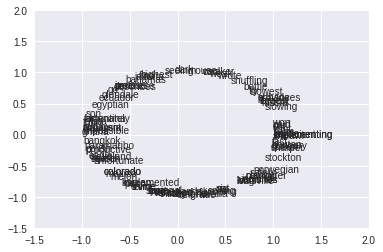

In [0]:
# run this cell only
vectors = pickle.load(open('pickle_vectors_TSNE','rb'))
% matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
i = 0
count = 0
while(count<100):
    #print(word, vectors[word2int[word]][1])
    word = test_words[np.random.randint(0,900)]
    if(isinvocab(word)):
      ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
      count = count+1
      i = i+1
    else:
      i = i+1
plt.xlim(-1.5,2)
plt.ylim(-1.5,2)
plt.savefig("plot_{}words".format(count))
plt.show()